In [1]:
import pandas as pd
import numpy as np
import quandl
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
QUANDL_KEY = '2jxLk6YXWX8G9cKw-qCs'
quandl.ApiConfig.api_key = QUANDL_KEY
import pandas_datareader.data as web
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [125]:
df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',
start_date='2000-01-01',
end_date='2019-12-31')
df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last() #only last values of month

In [126]:
# i = pd.date_range('2018-04-09', periods=4, freq='2D')
# ts = pd.DataFrame({'A': [1, 2, 3, 4]}, index=i)
# ts
            #A
#2018-04-09  1
#2018-04-11  2
#2018-04-13  3
#2018-04-15  4

#ts.last('3D')
            #A
#2018-04-13  3
#2018-04-15  4

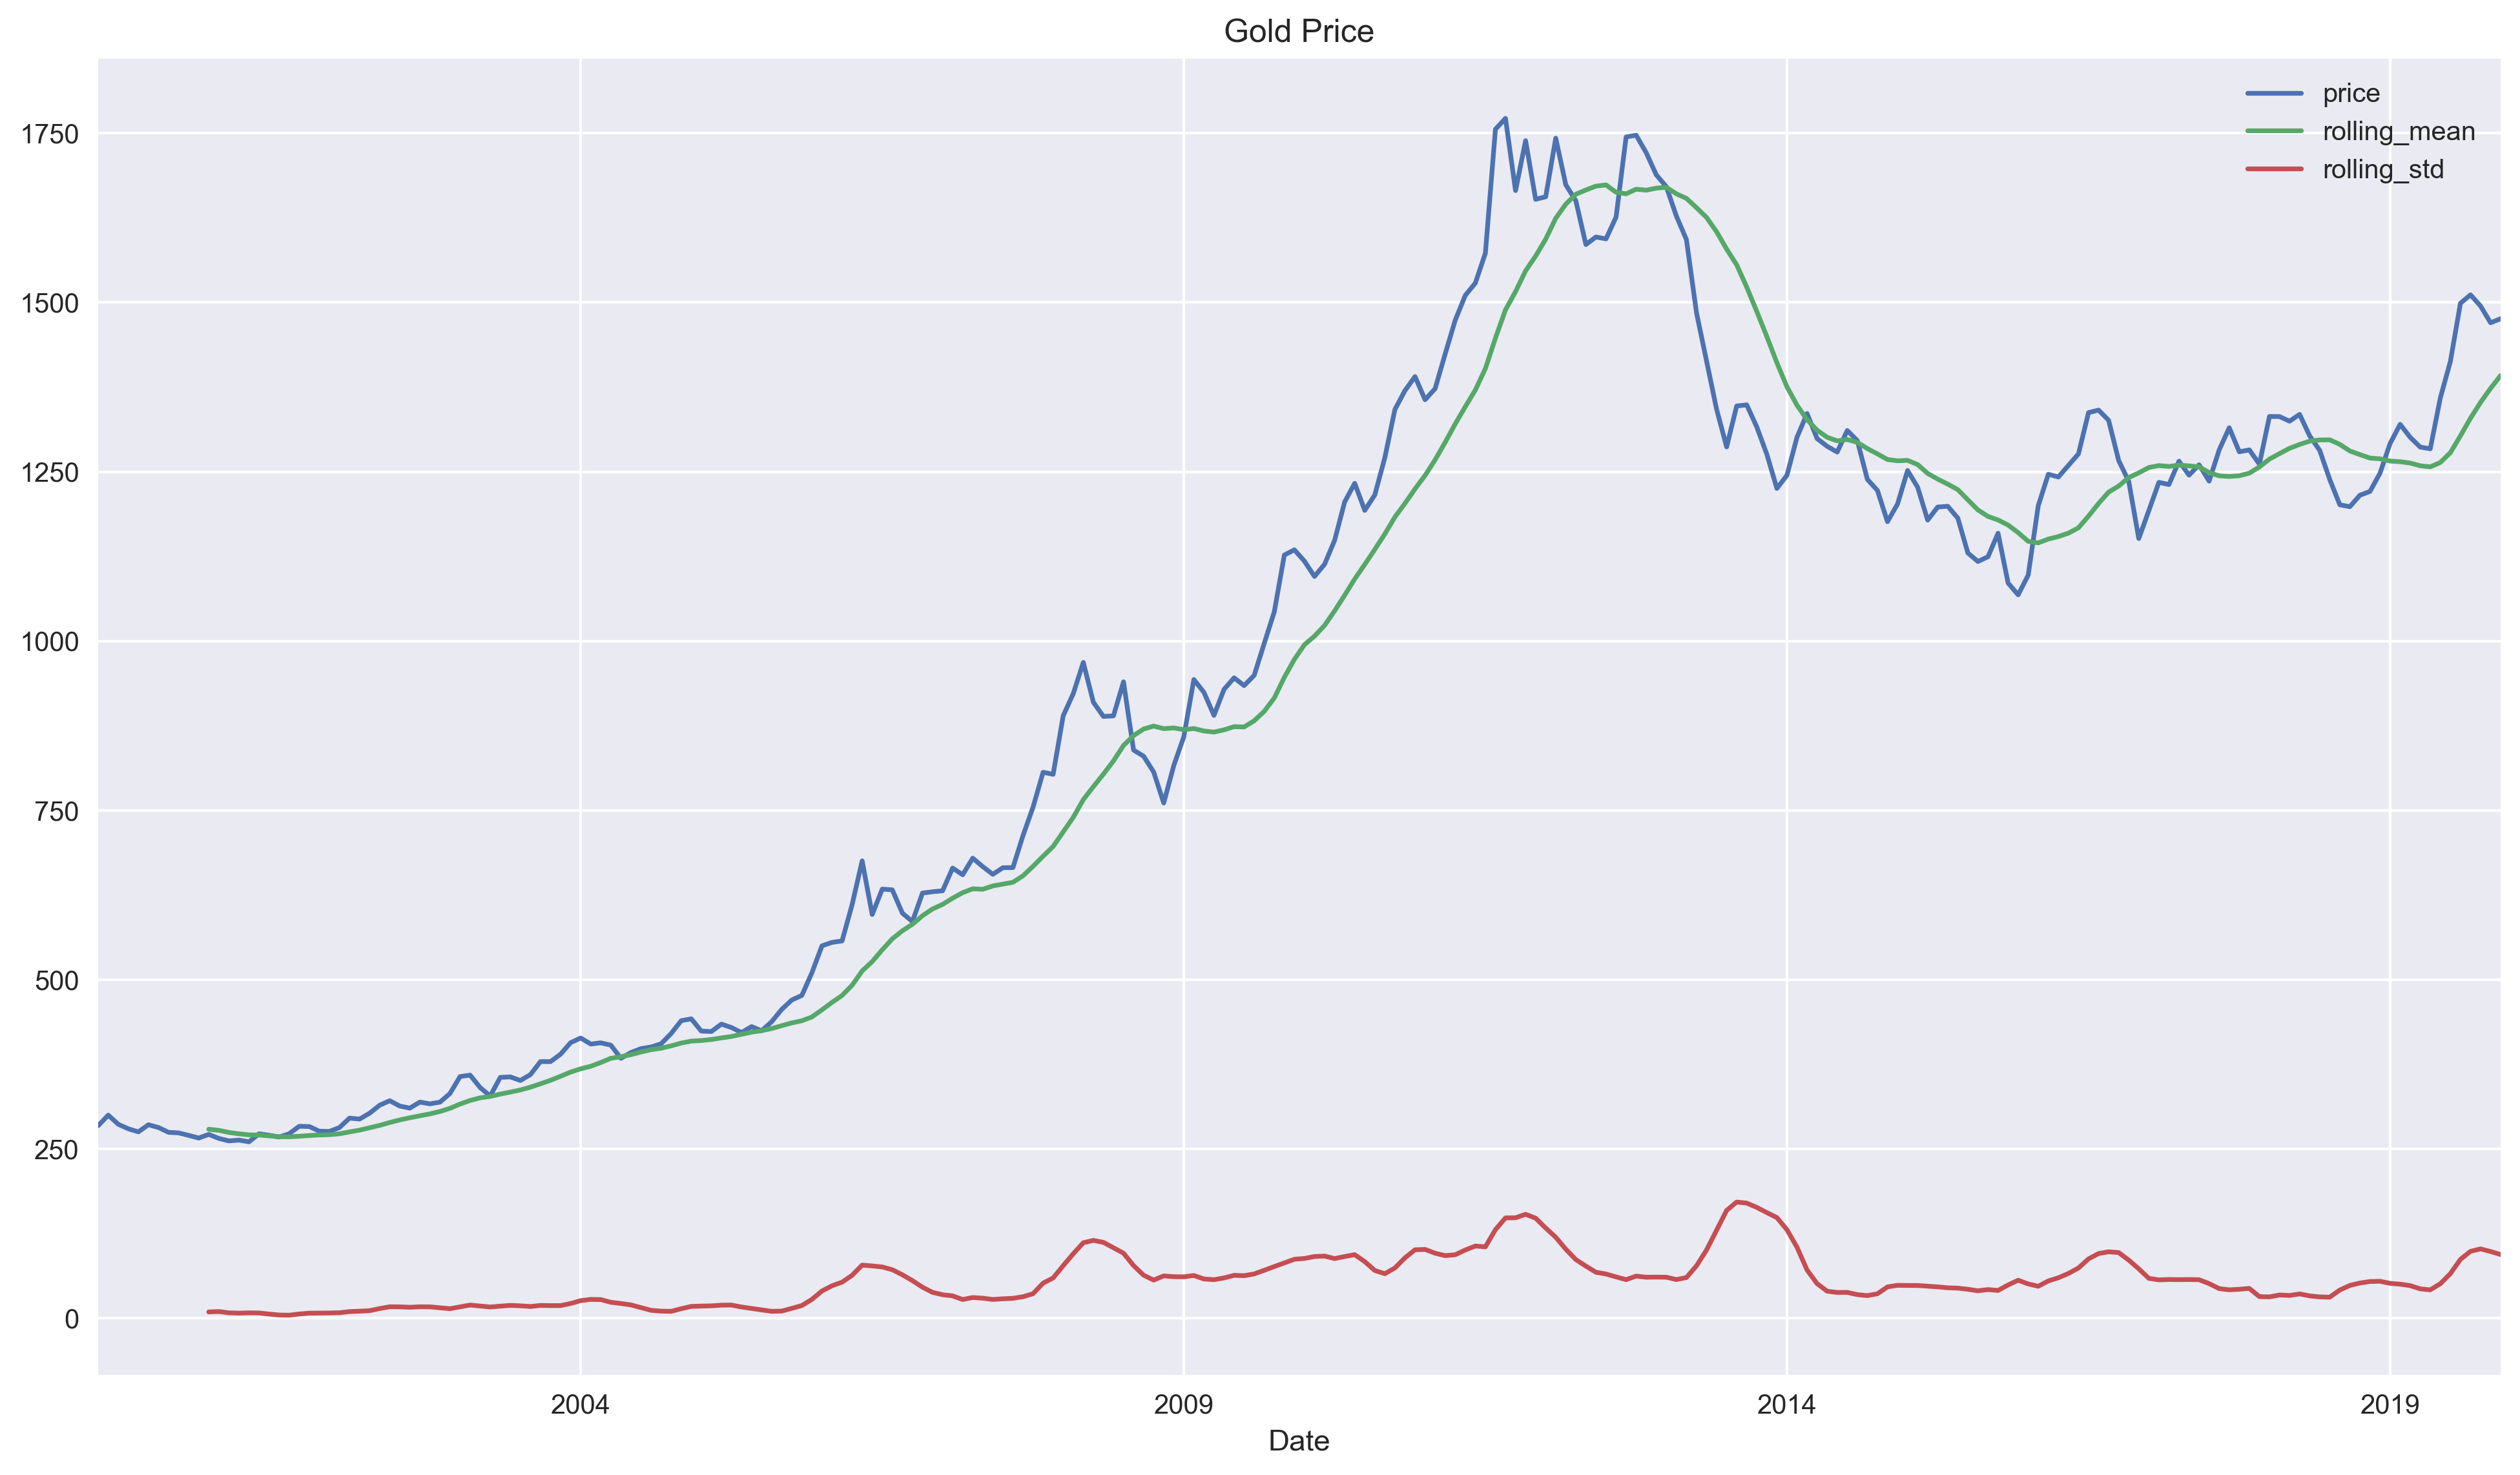

In [127]:
WINDOW_SIZE = 12
df['rolling_mean'] = df.price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.price.rolling(window=WINDOW_SIZE).std()
df.plot(title='Gold Price')
plt.style.use('bmh')

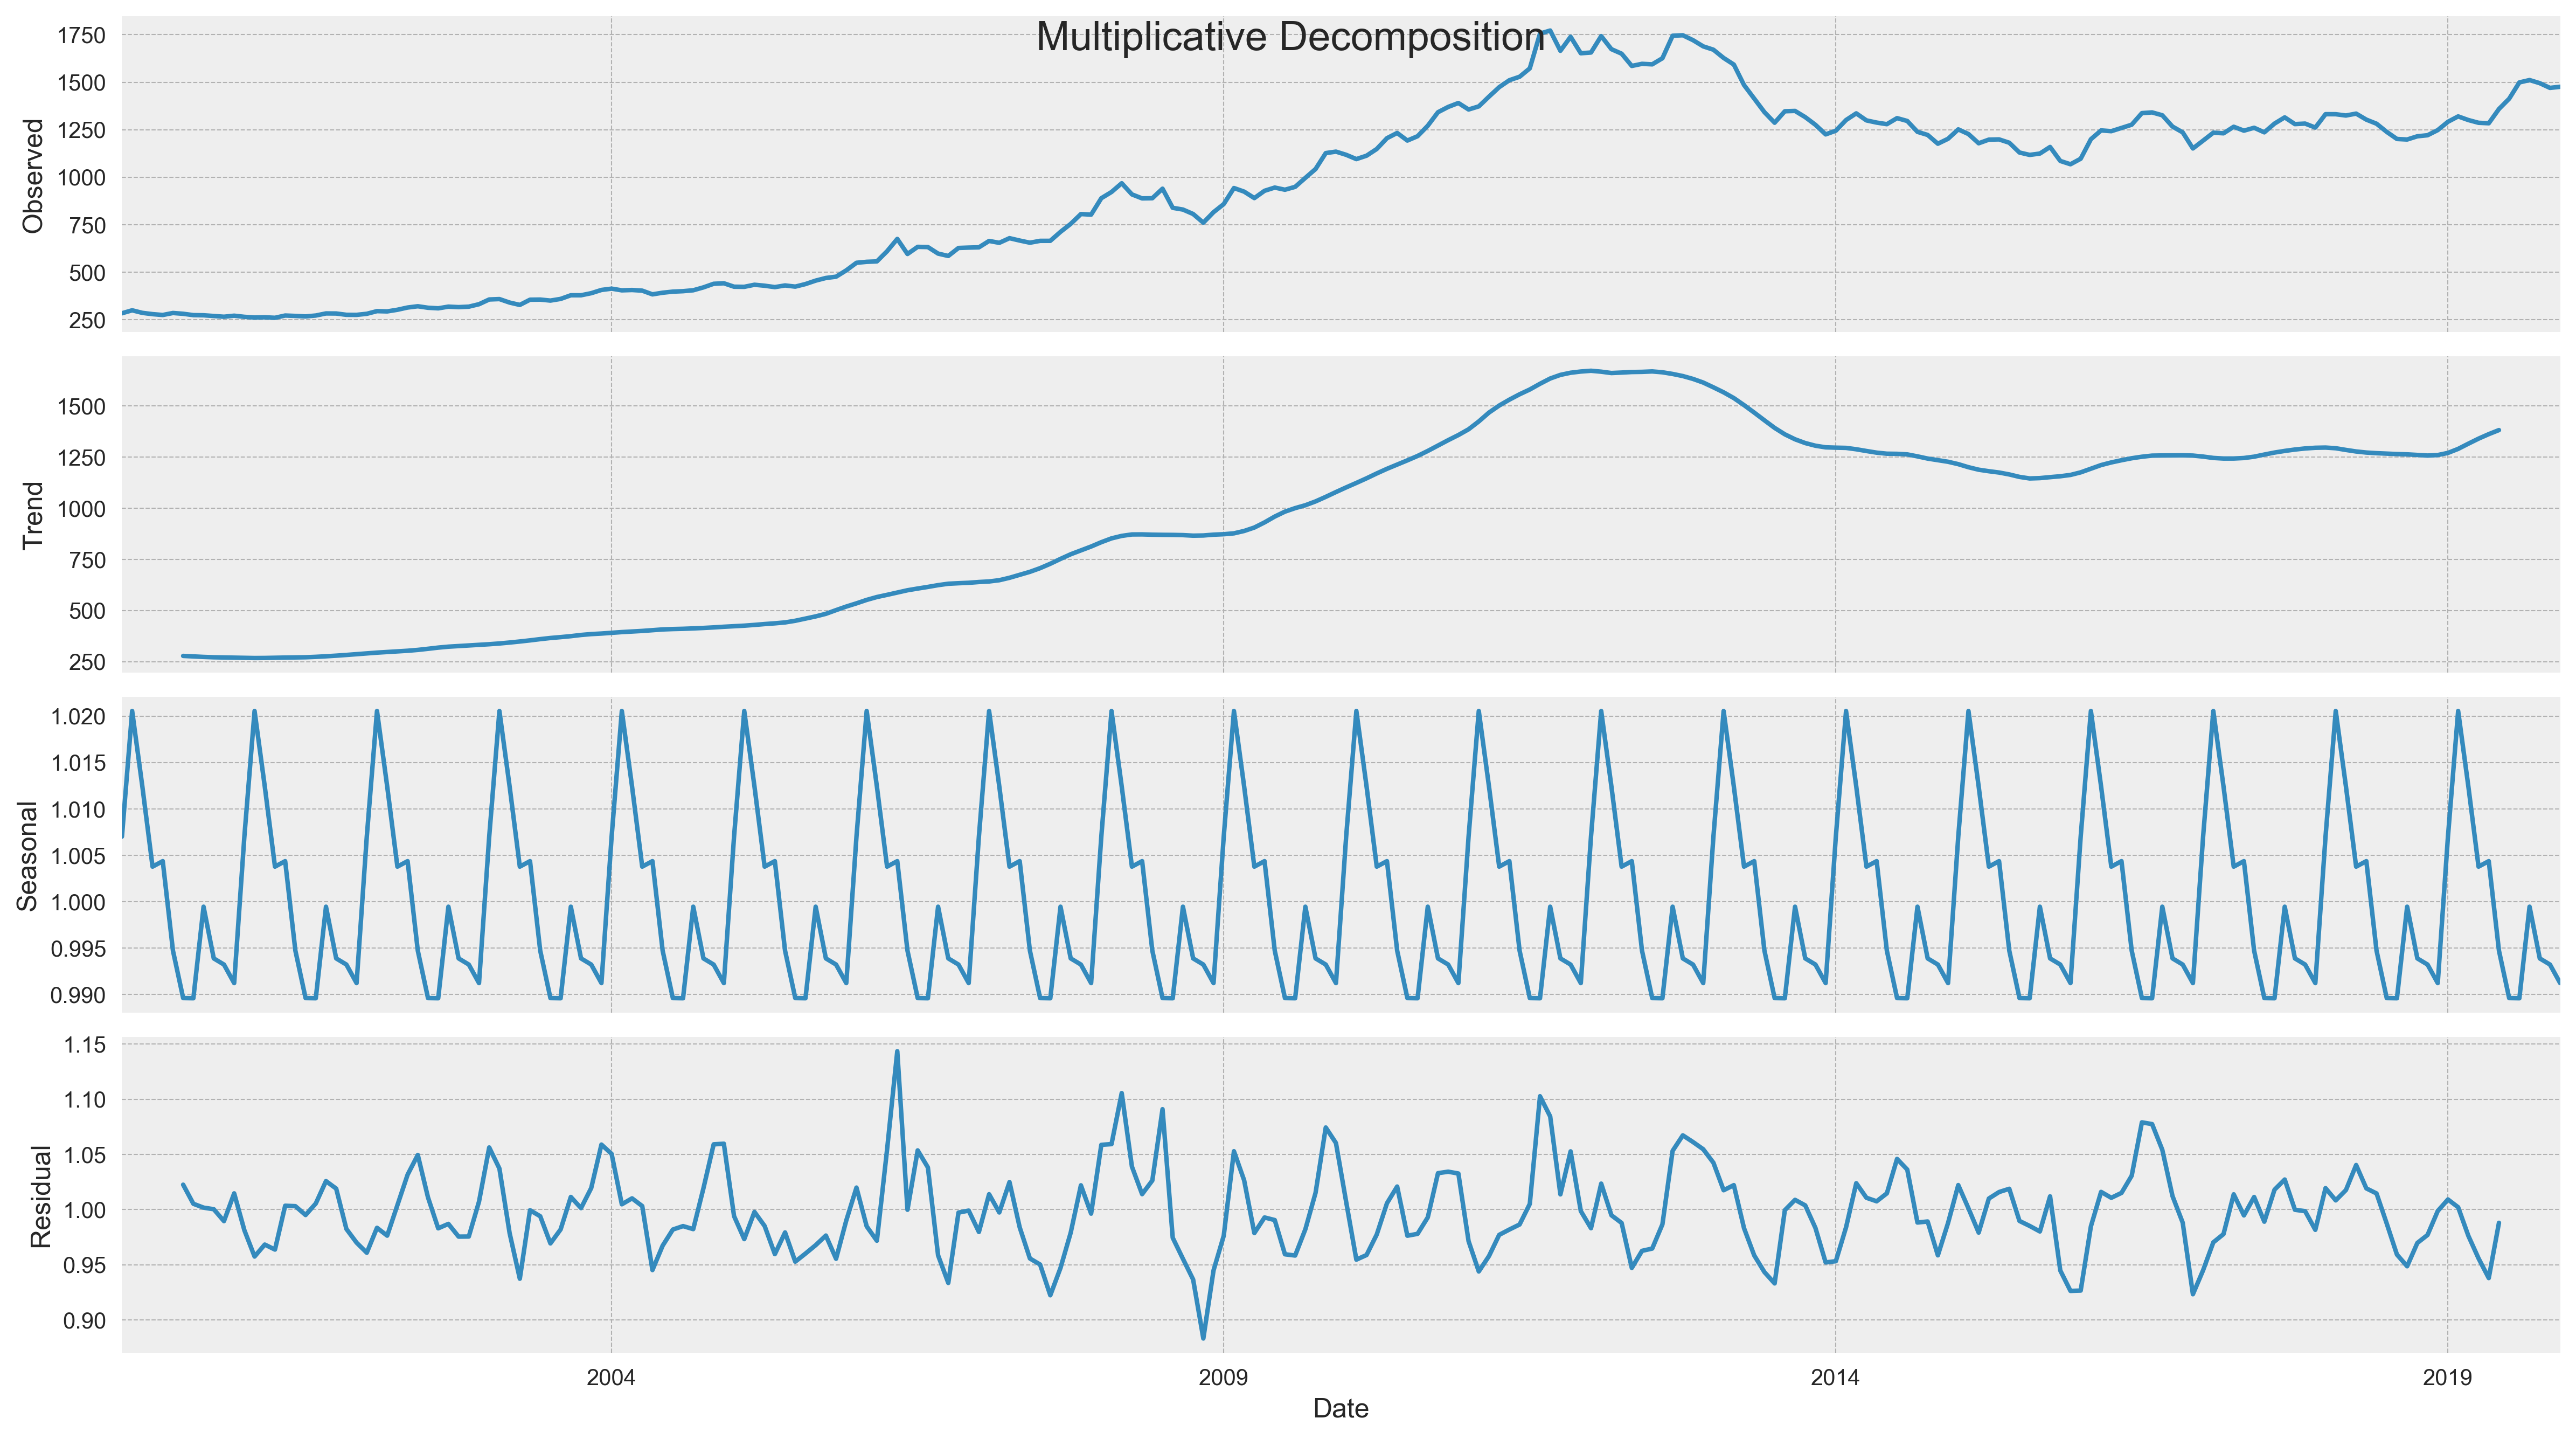

In [128]:
decomposition_results = seasonal_decompose(df.price, model='multiplicative')
decomposition_results.plot().suptitle('Multiplicative Decomposition', fontsize=18);

In [129]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [130]:
result = adfuller(df.price)
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.9369534115415584
p-value : 0.77555974173863
#Lags Used : 1
Number of Observations Used : 238
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [131]:
def kpss_test(x, h0_type='c'):
    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
    return results

In [132]:
kpss_test(df.price)

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Test Statistic            1.315021
p-value                   0.010000
# of Lags                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

In [133]:
# The null hypothesis of the KPSS test is that the time series is stationary. With a pvalue
# of 0.01 (or test statistic greater than the selected critical value), we have
# reasons to reject the null hypothesis in favor of the alternative one, meaning that
# the series is not stationary.

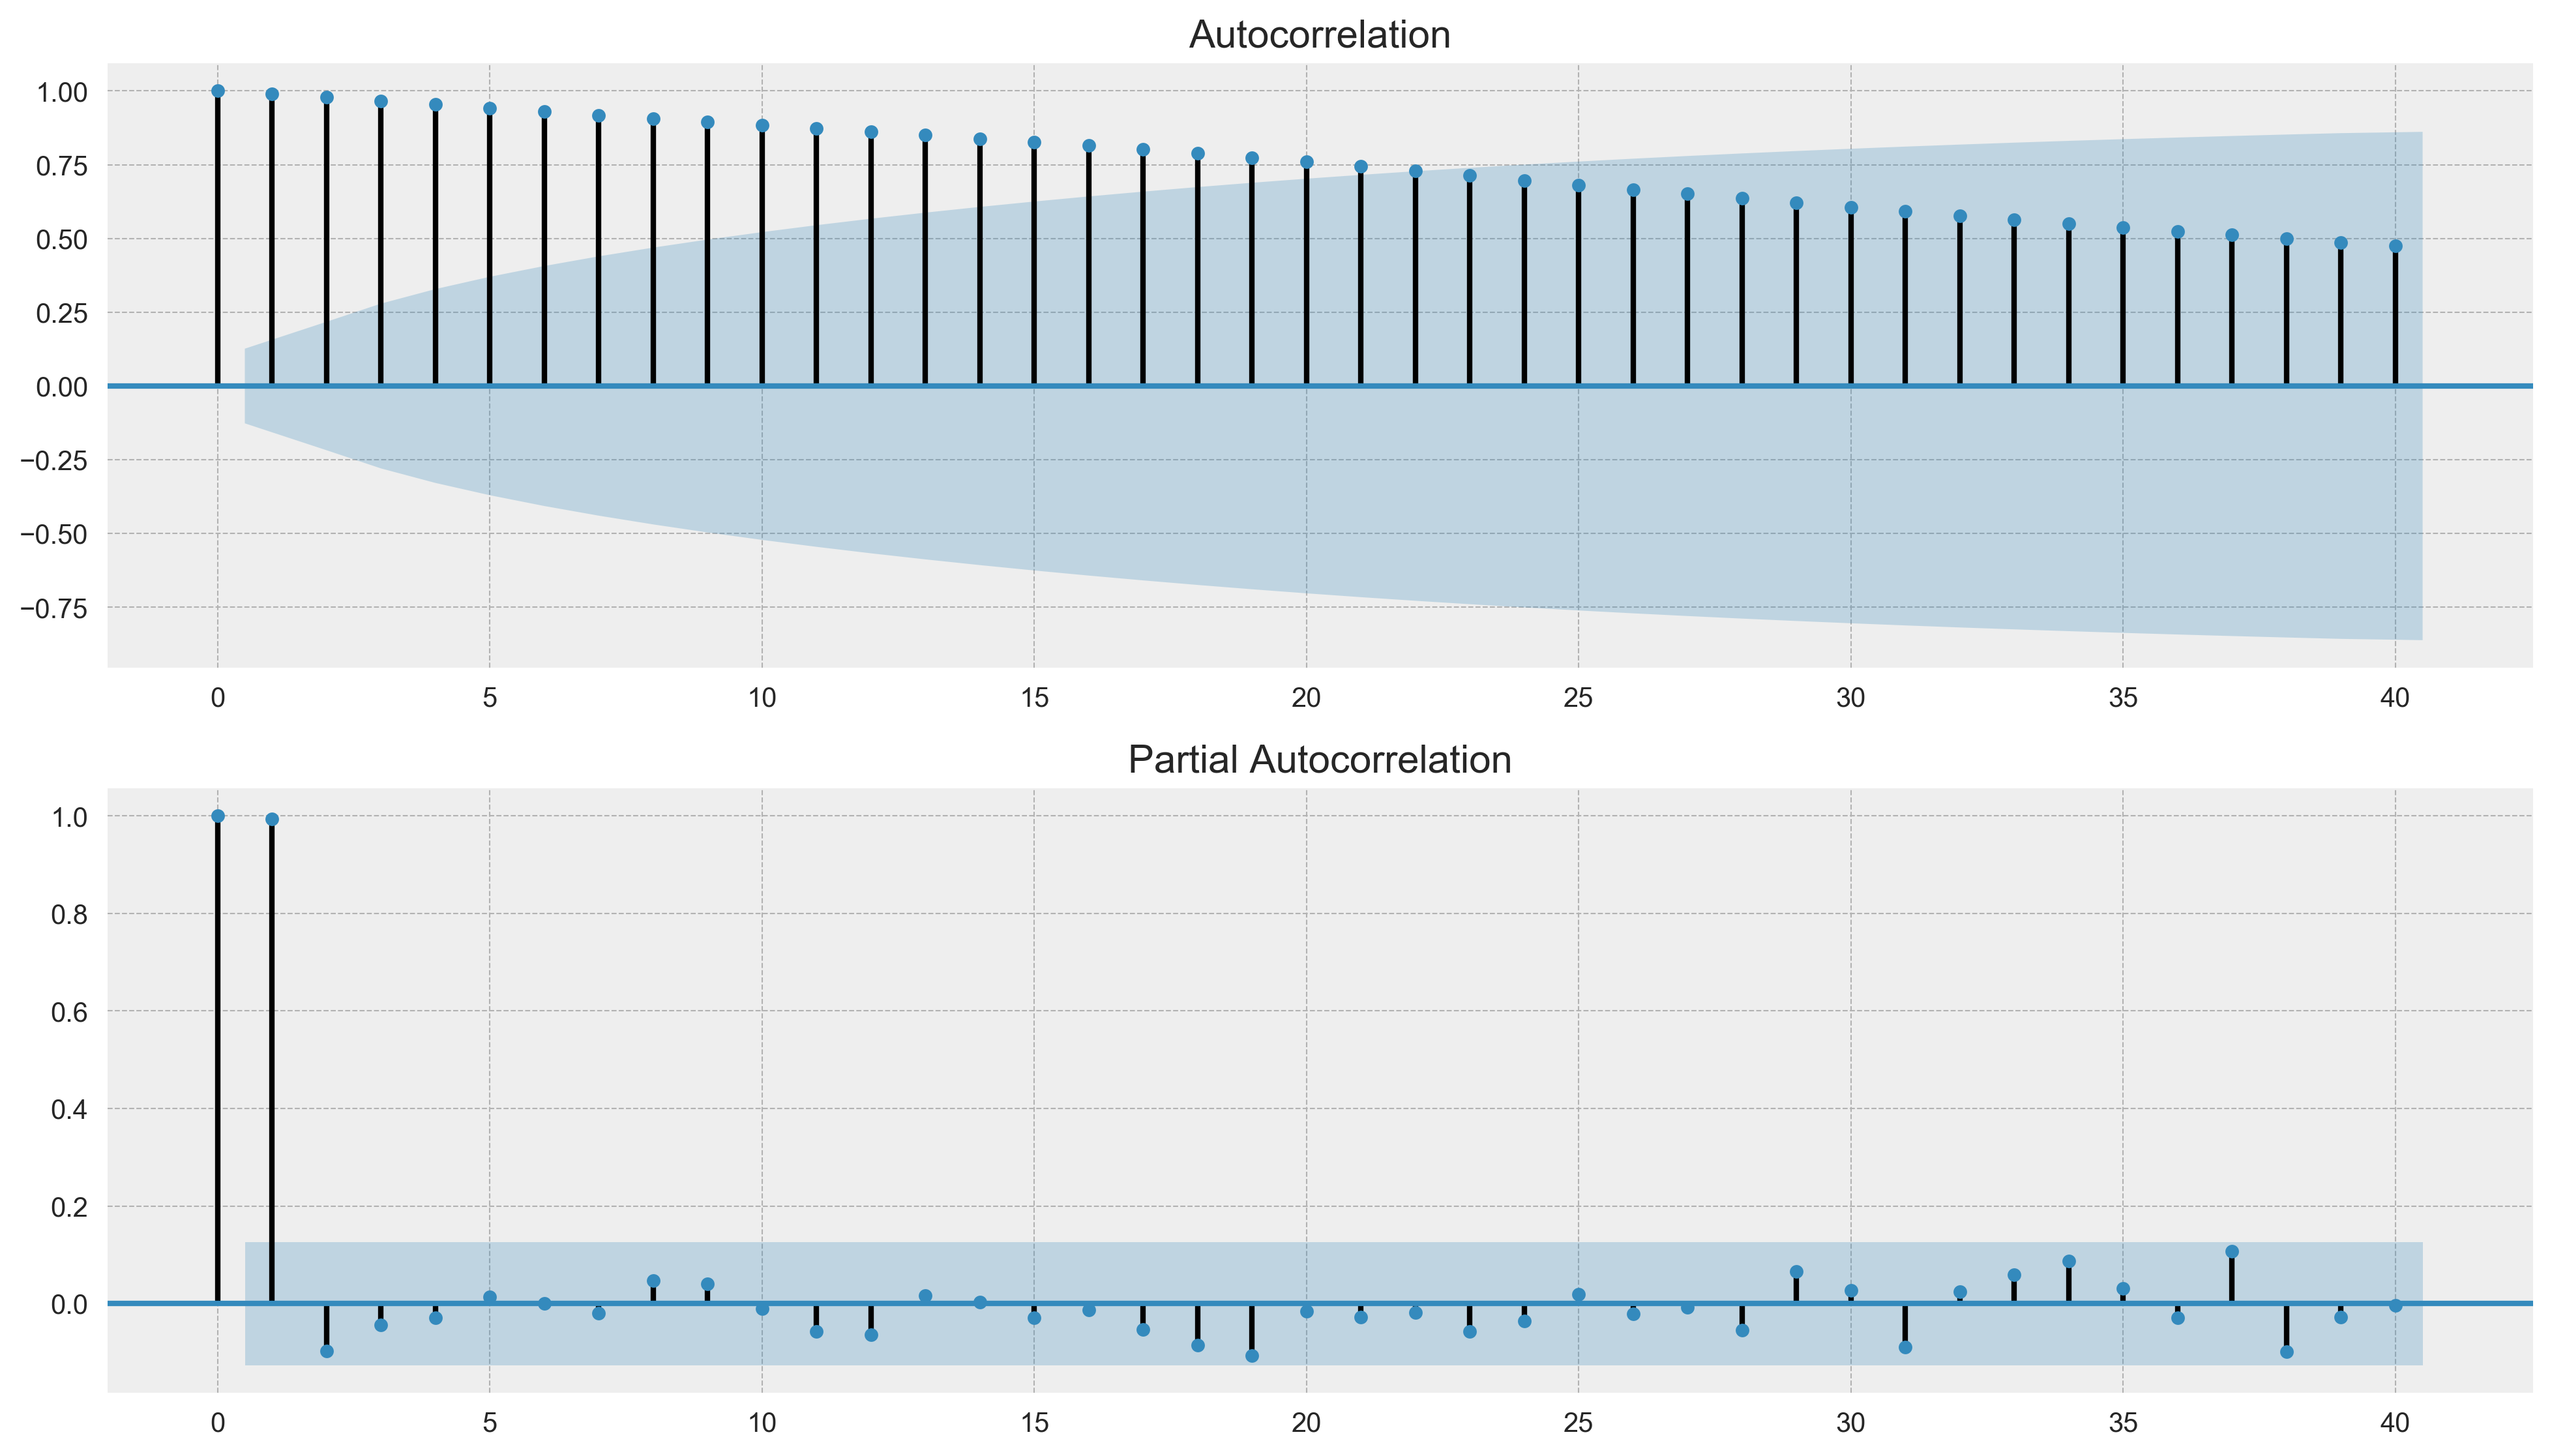

In [134]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2,1)
plot_acf(df.price, ax=ax[0], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df.price, ax=ax[1], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL);


In [135]:
# In the ACF plot, we can see that there are significant autocorrelations (above the
# 95% confidence interval, corresponding to the selected 5% significance level).

In [136]:
'''
We can employ the following tests to investigate stationarity: ADF, KPSS, and
Phillips–Perron (PP):
from pmdarima.arima import ndiffs, nsdiffs
print(f"Suggested # of differences (ADF): {ndiffs(df.price, test='adf')}")
print(f"Suggested # of differences (KPSS): {ndiffs(df.price,
test='kpss')}")
print(f"Suggested # of differences (PP): {ndiffs(df.price, test='pp')}")
The output of the preceding code is as follows:
Suggested # of differences (ADF): 1
Suggested # of differences (KPSS): 2
Suggested # of differences (PP): 1
'''

'\nWe can employ the following tests to investigate stationarity: ADF, KPSS, and\nPhillips–Perron (PP):\nfrom pmdarima.arima import ndiffs, nsdiffs\nprint(f"Suggested # of differences (ADF): {ndiffs(df.price, test=\'adf\')}")\nprint(f"Suggested # of differences (KPSS): {ndiffs(df.price,\ntest=\'kpss\')}")\nprint(f"Suggested # of differences (PP): {ndiffs(df.price, test=\'pp\')}")\nThe output of the preceding code is as follows:\nSuggested # of differences (ADF): 1\nSuggested # of differences (KPSS): 2\nSuggested # of differences (PP): 1\n'

In [137]:
import seaborn as sns
plt.set_cmap('cubehelix')
sns.set_palette('cubehelix')
COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]

<Figure size 4800x2700 with 0 Axes>

In [138]:
import yfinance as yf
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, SimpleExpSmoothing, Holt)
df = yf.download('USDTRY=X', start='2010-01-01', end='2020-04-06', adjusted=True, progress=False)


In [139]:
usdtry = df.resample('M').last().rename(columns={'Adj Close' : 'adj_close'}).adj_close

In [224]:
train_indices = usdtry.index.year < 2018
usdtry_train = usdtry[train_indices]
usdtry_test = usdtry[~train_indices]
test_length = len(usdtry_test)

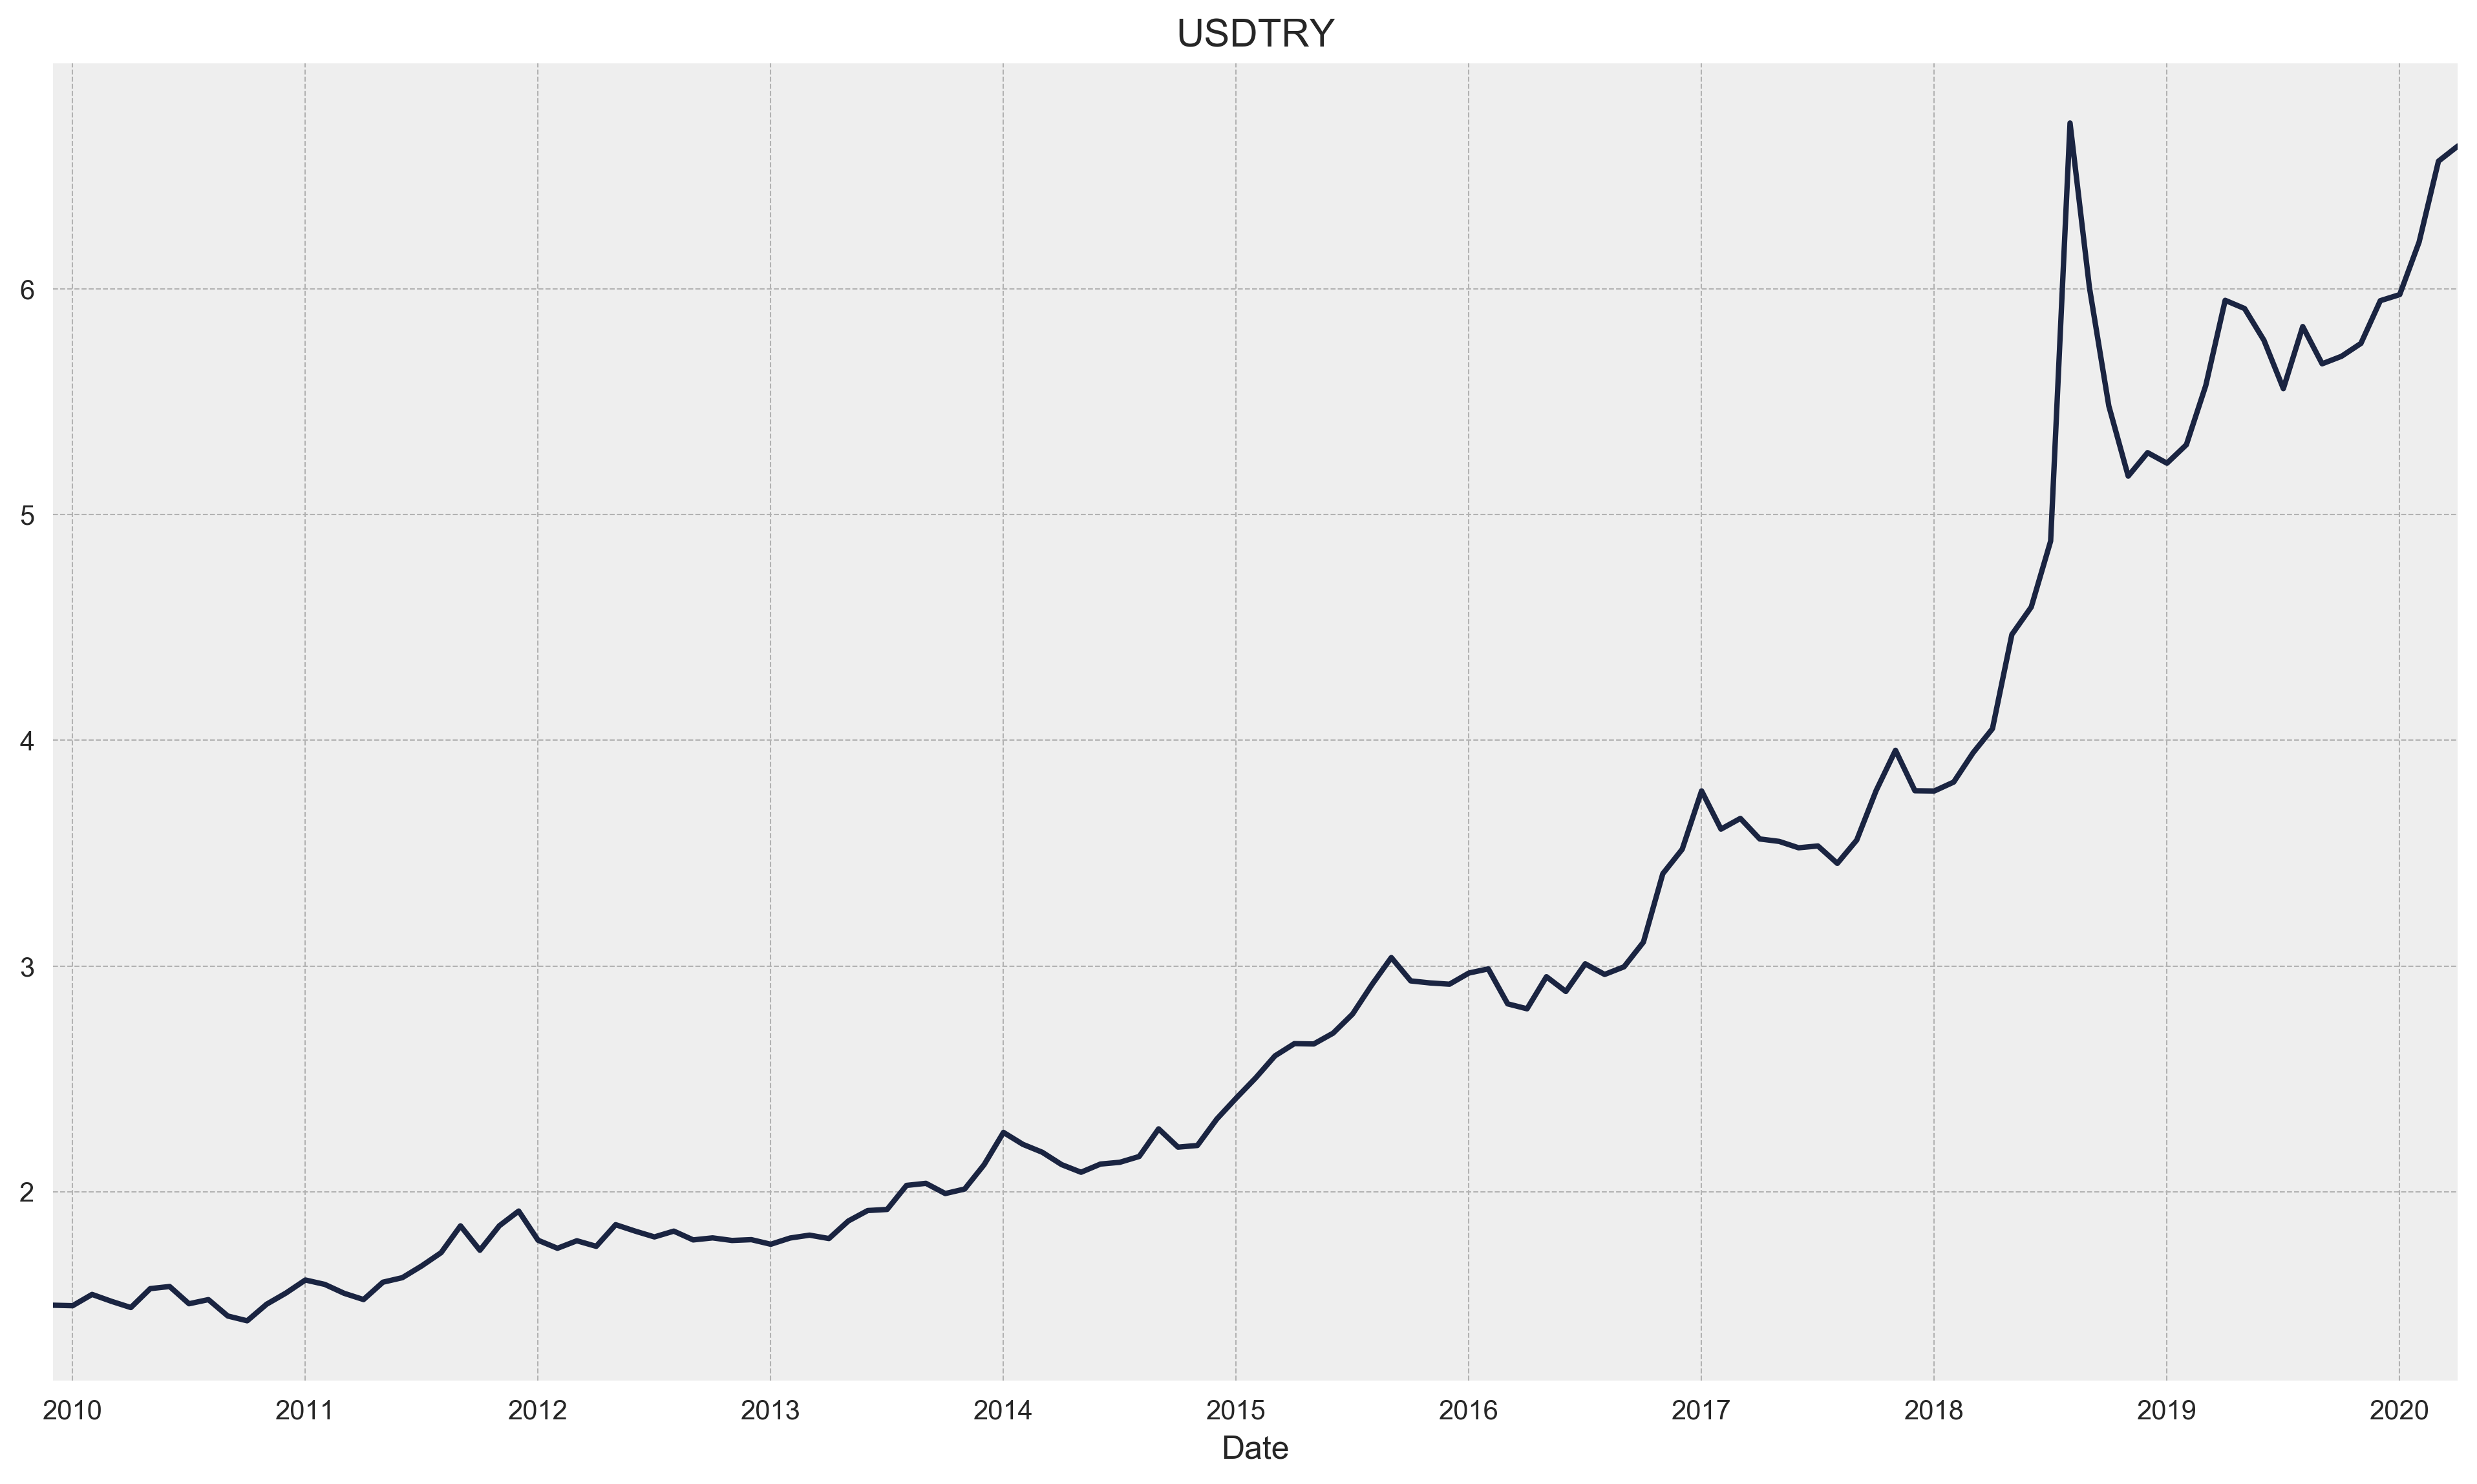

In [210]:
usdtry.plot(title="USDTRY")

In [211]:
ses_1 = SimpleExpSmoothing(usdtry_train).fit(smoothing_level=0.2)
ses_forecast_1 = ses_1.forecast(test_length)
ses_2 = SimpleExpSmoothing(usdtry_train).fit(smoothing_level=0.5)
ses_forecast_2 = ses_2.forecast(test_length)
ses_3 = SimpleExpSmoothing(usdtry_train).fit()
alpha = ses_3.model.params['smoothing_level']
ses_forecast_3 = ses_3.forecast(test_length)

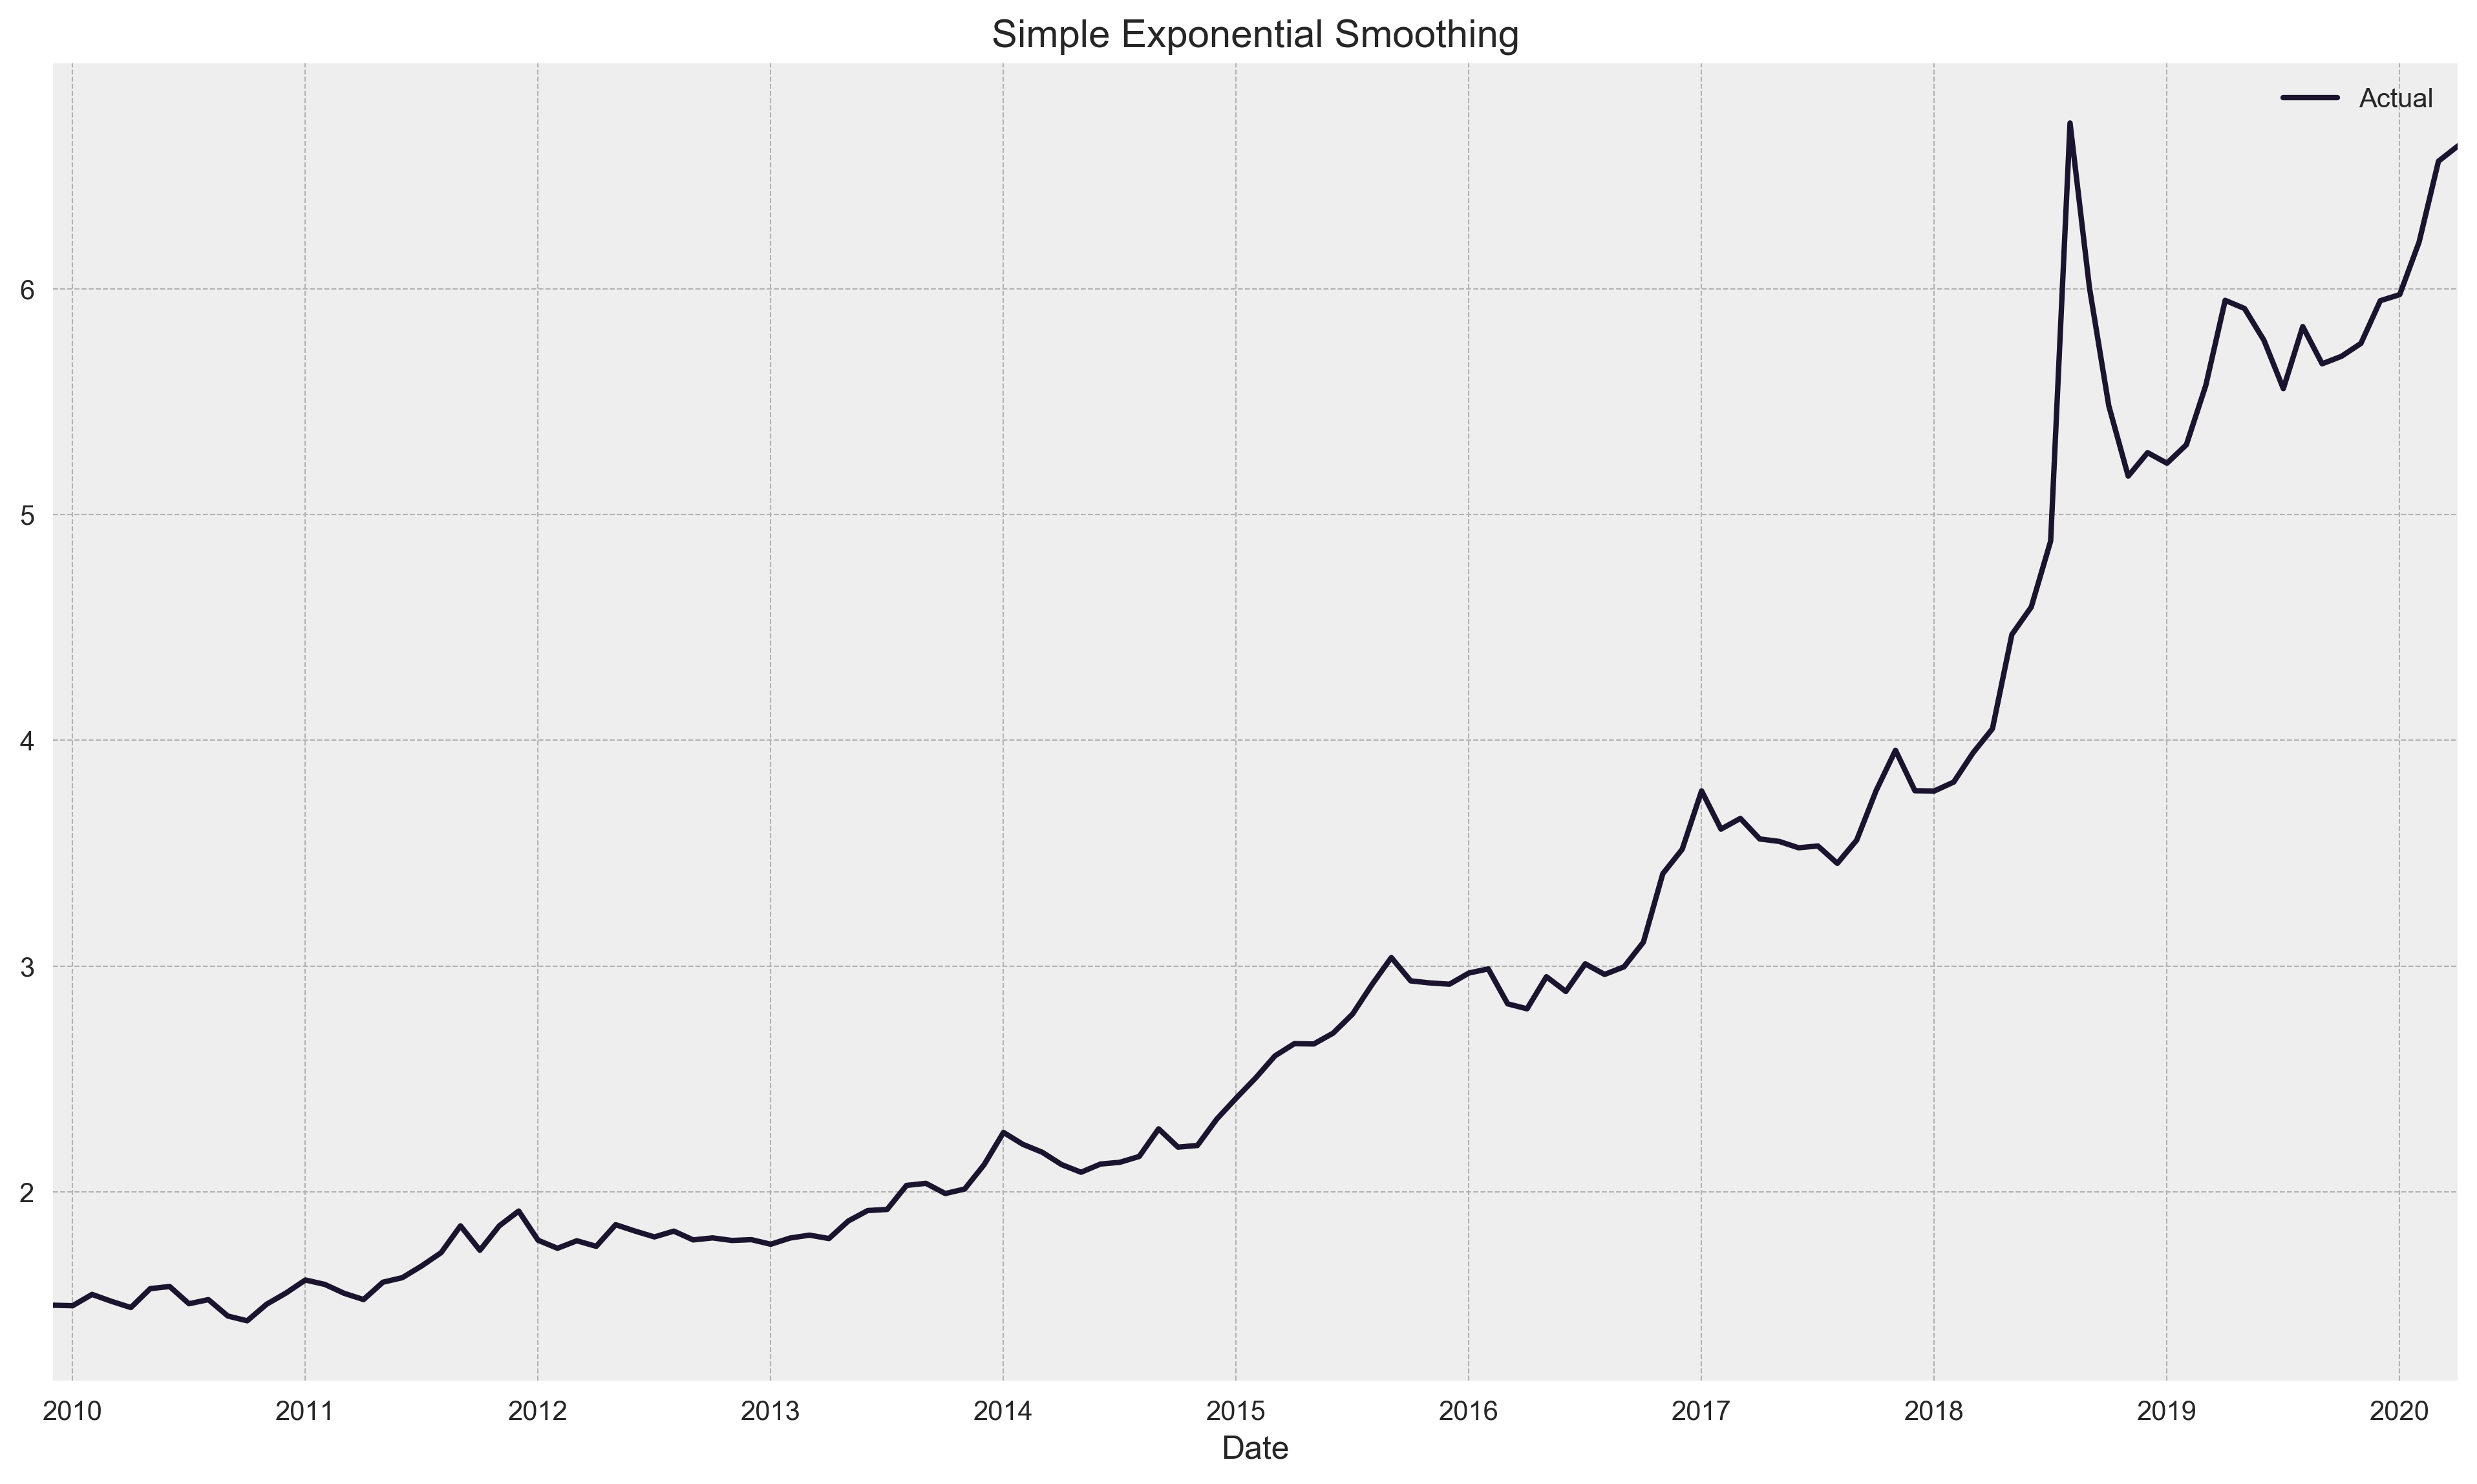

In [212]:
usdtry.plot(color=COLORS[0], title='Simple Exponential Smoothing', label='Actual', legend=True)

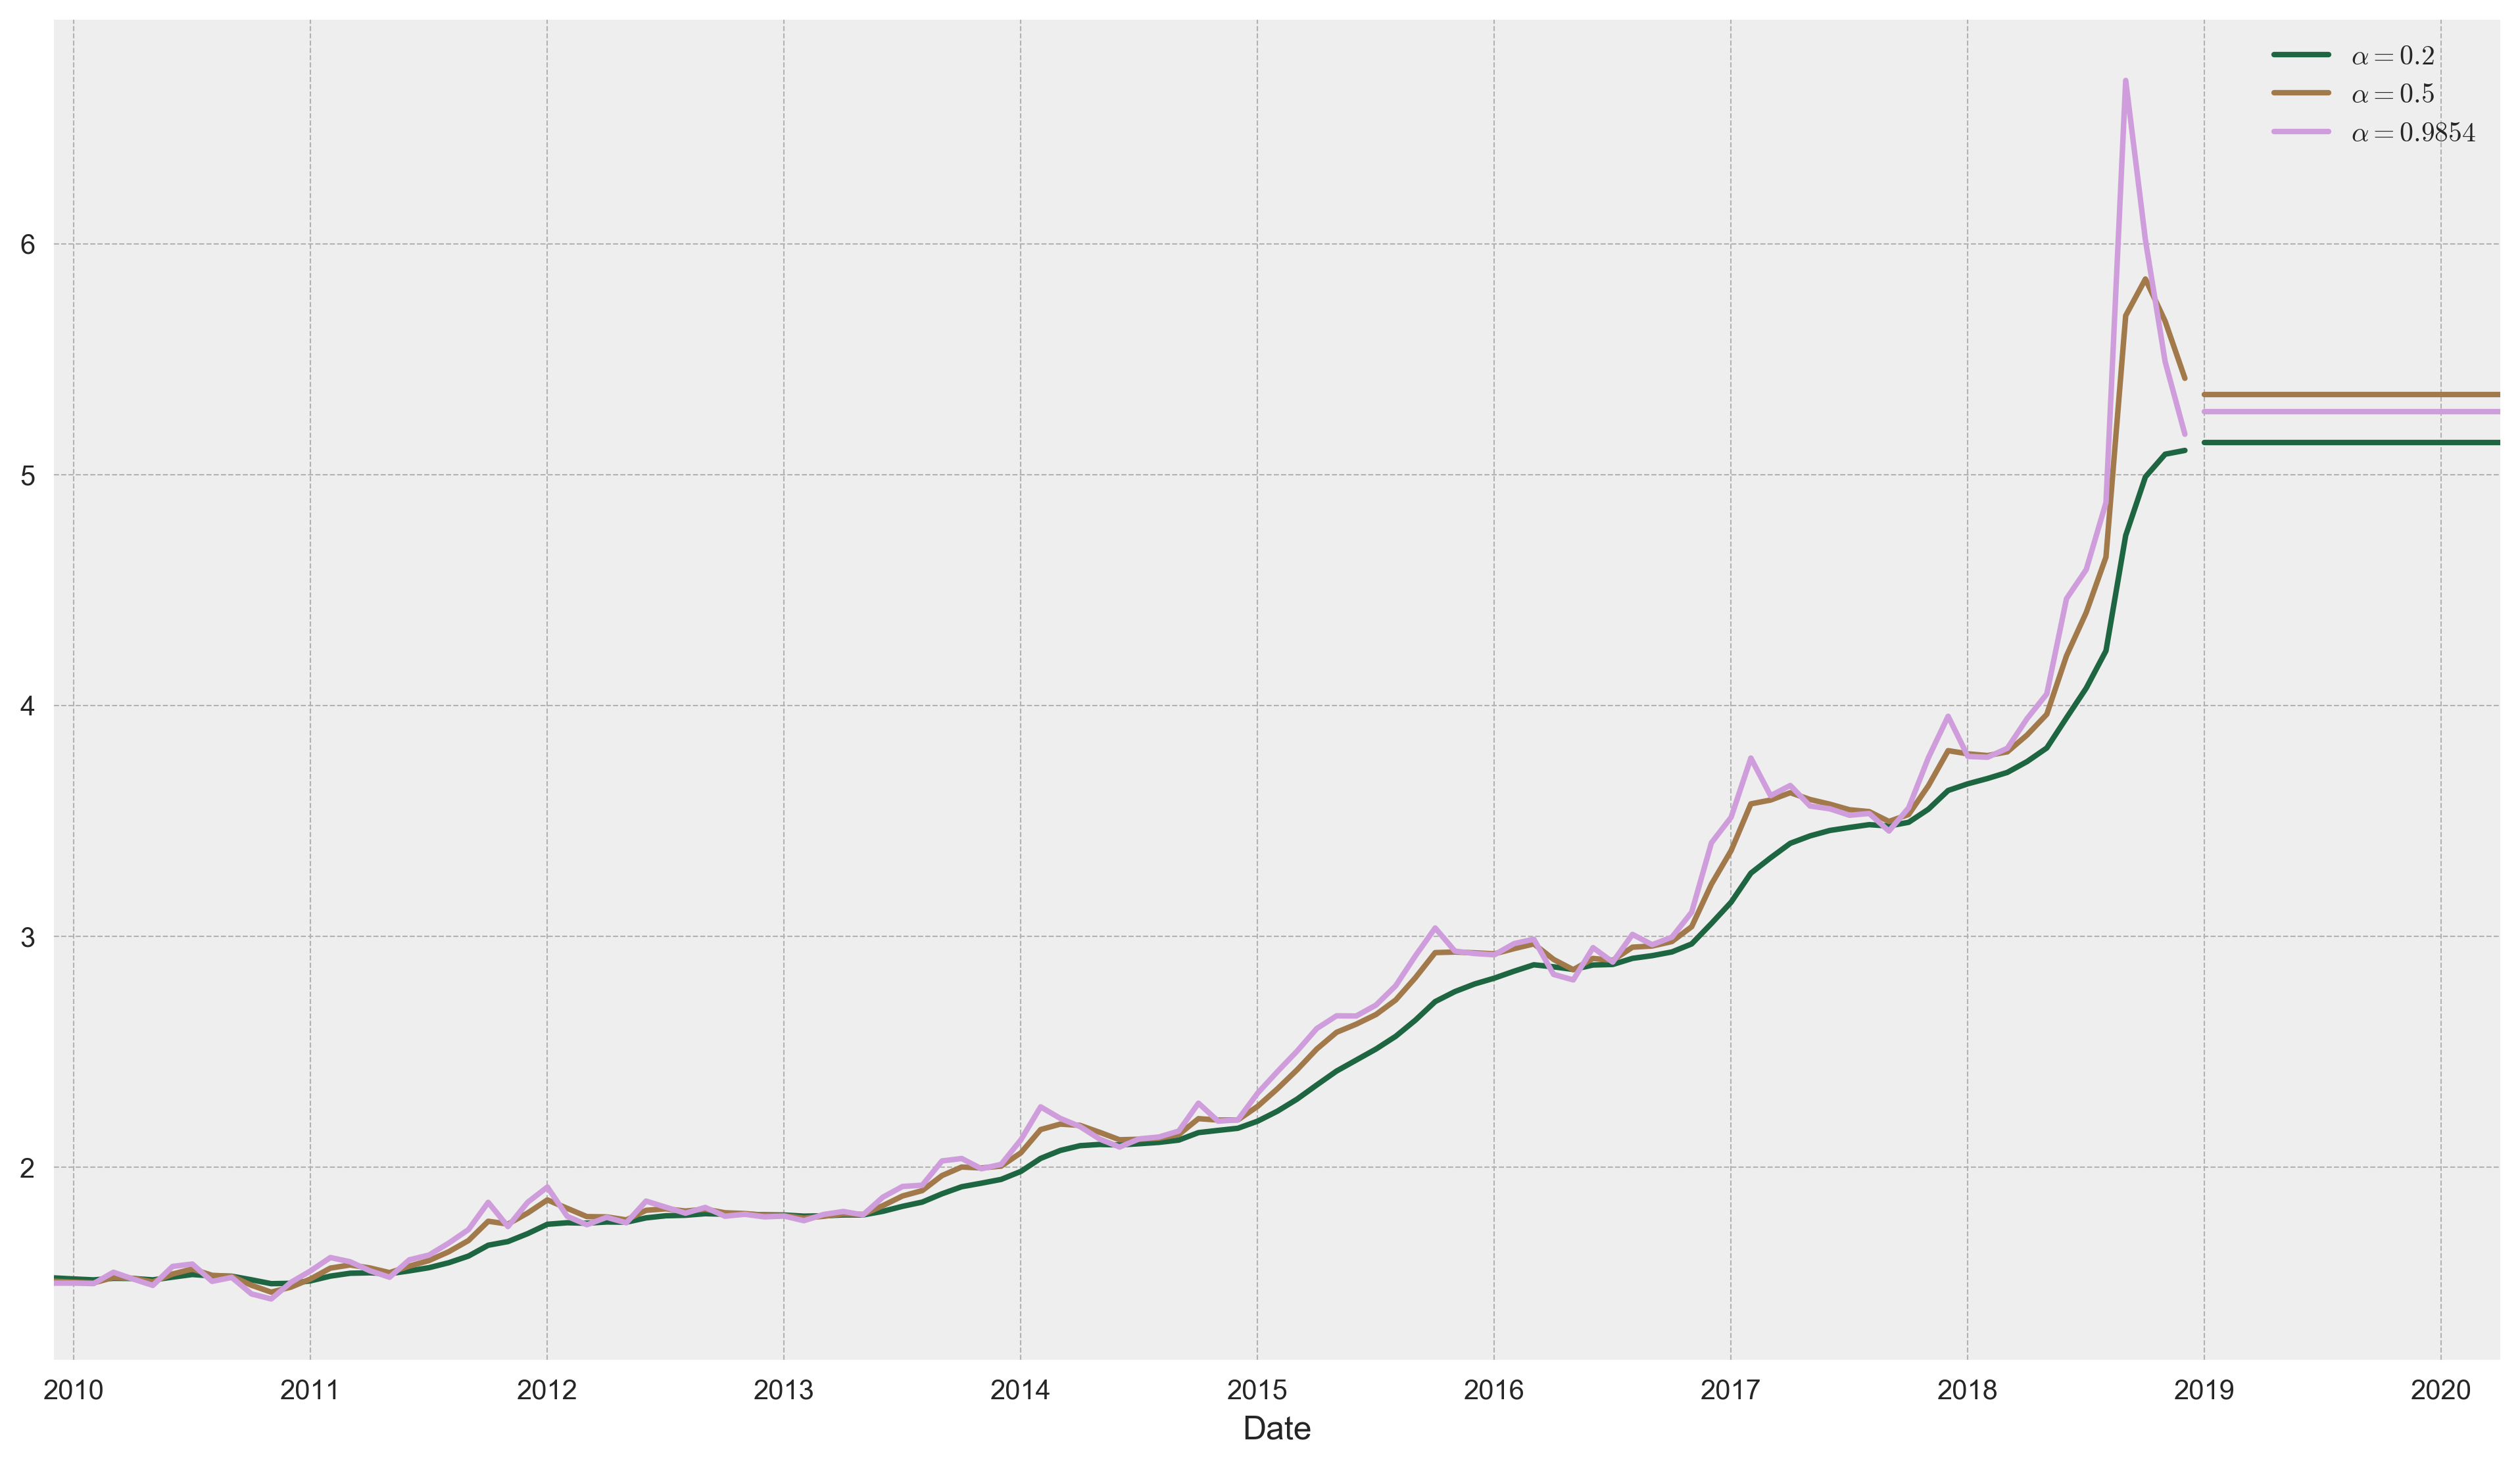

In [213]:
ses_forecast_1.plot(color=COLORS[1], legend=True, label=r'$\alpha=0.2$')
ses_1.fittedvalues.plot(color=COLORS[1])
ses_forecast_2.plot(color=COLORS[2], legend=True, label=r'$\alpha=0.5$')
ses_2.fittedvalues.plot(color=COLORS[2])
ses_forecast_3.plot(color=COLORS[3], legend=True, label=r'$\alpha={0:.4f}$'.format(alpha))
ses_3.fittedvalues.plot(color=COLORS[3])
# the model performs a poor performance because the data has a trend
# when there is a trend Holt's forecast is more viable

In [214]:
# Holt's model with linear trend
hs_1 = Holt(usdtry_train).fit()
hs_forecast_1 = hs_1.forecast(test_length)
# Holt's model with exponential trend
hs_2 = Holt(usdtry_train, exponential=True).fit()
hs_forecast_2 = hs_2.forecast(test_length)
# Holt's model with exponential trend and damping
hs_3 = Holt(usdtry_train, exponential=False, damped=True).fit(damping_slope=0.9)
hs_forecast_3 = hs_3.forecast(test_length)
Holt(usdtry_train, exponential=True) # is equivalent to
ExponentialSmoothing(usdtry_train, trend='mul')

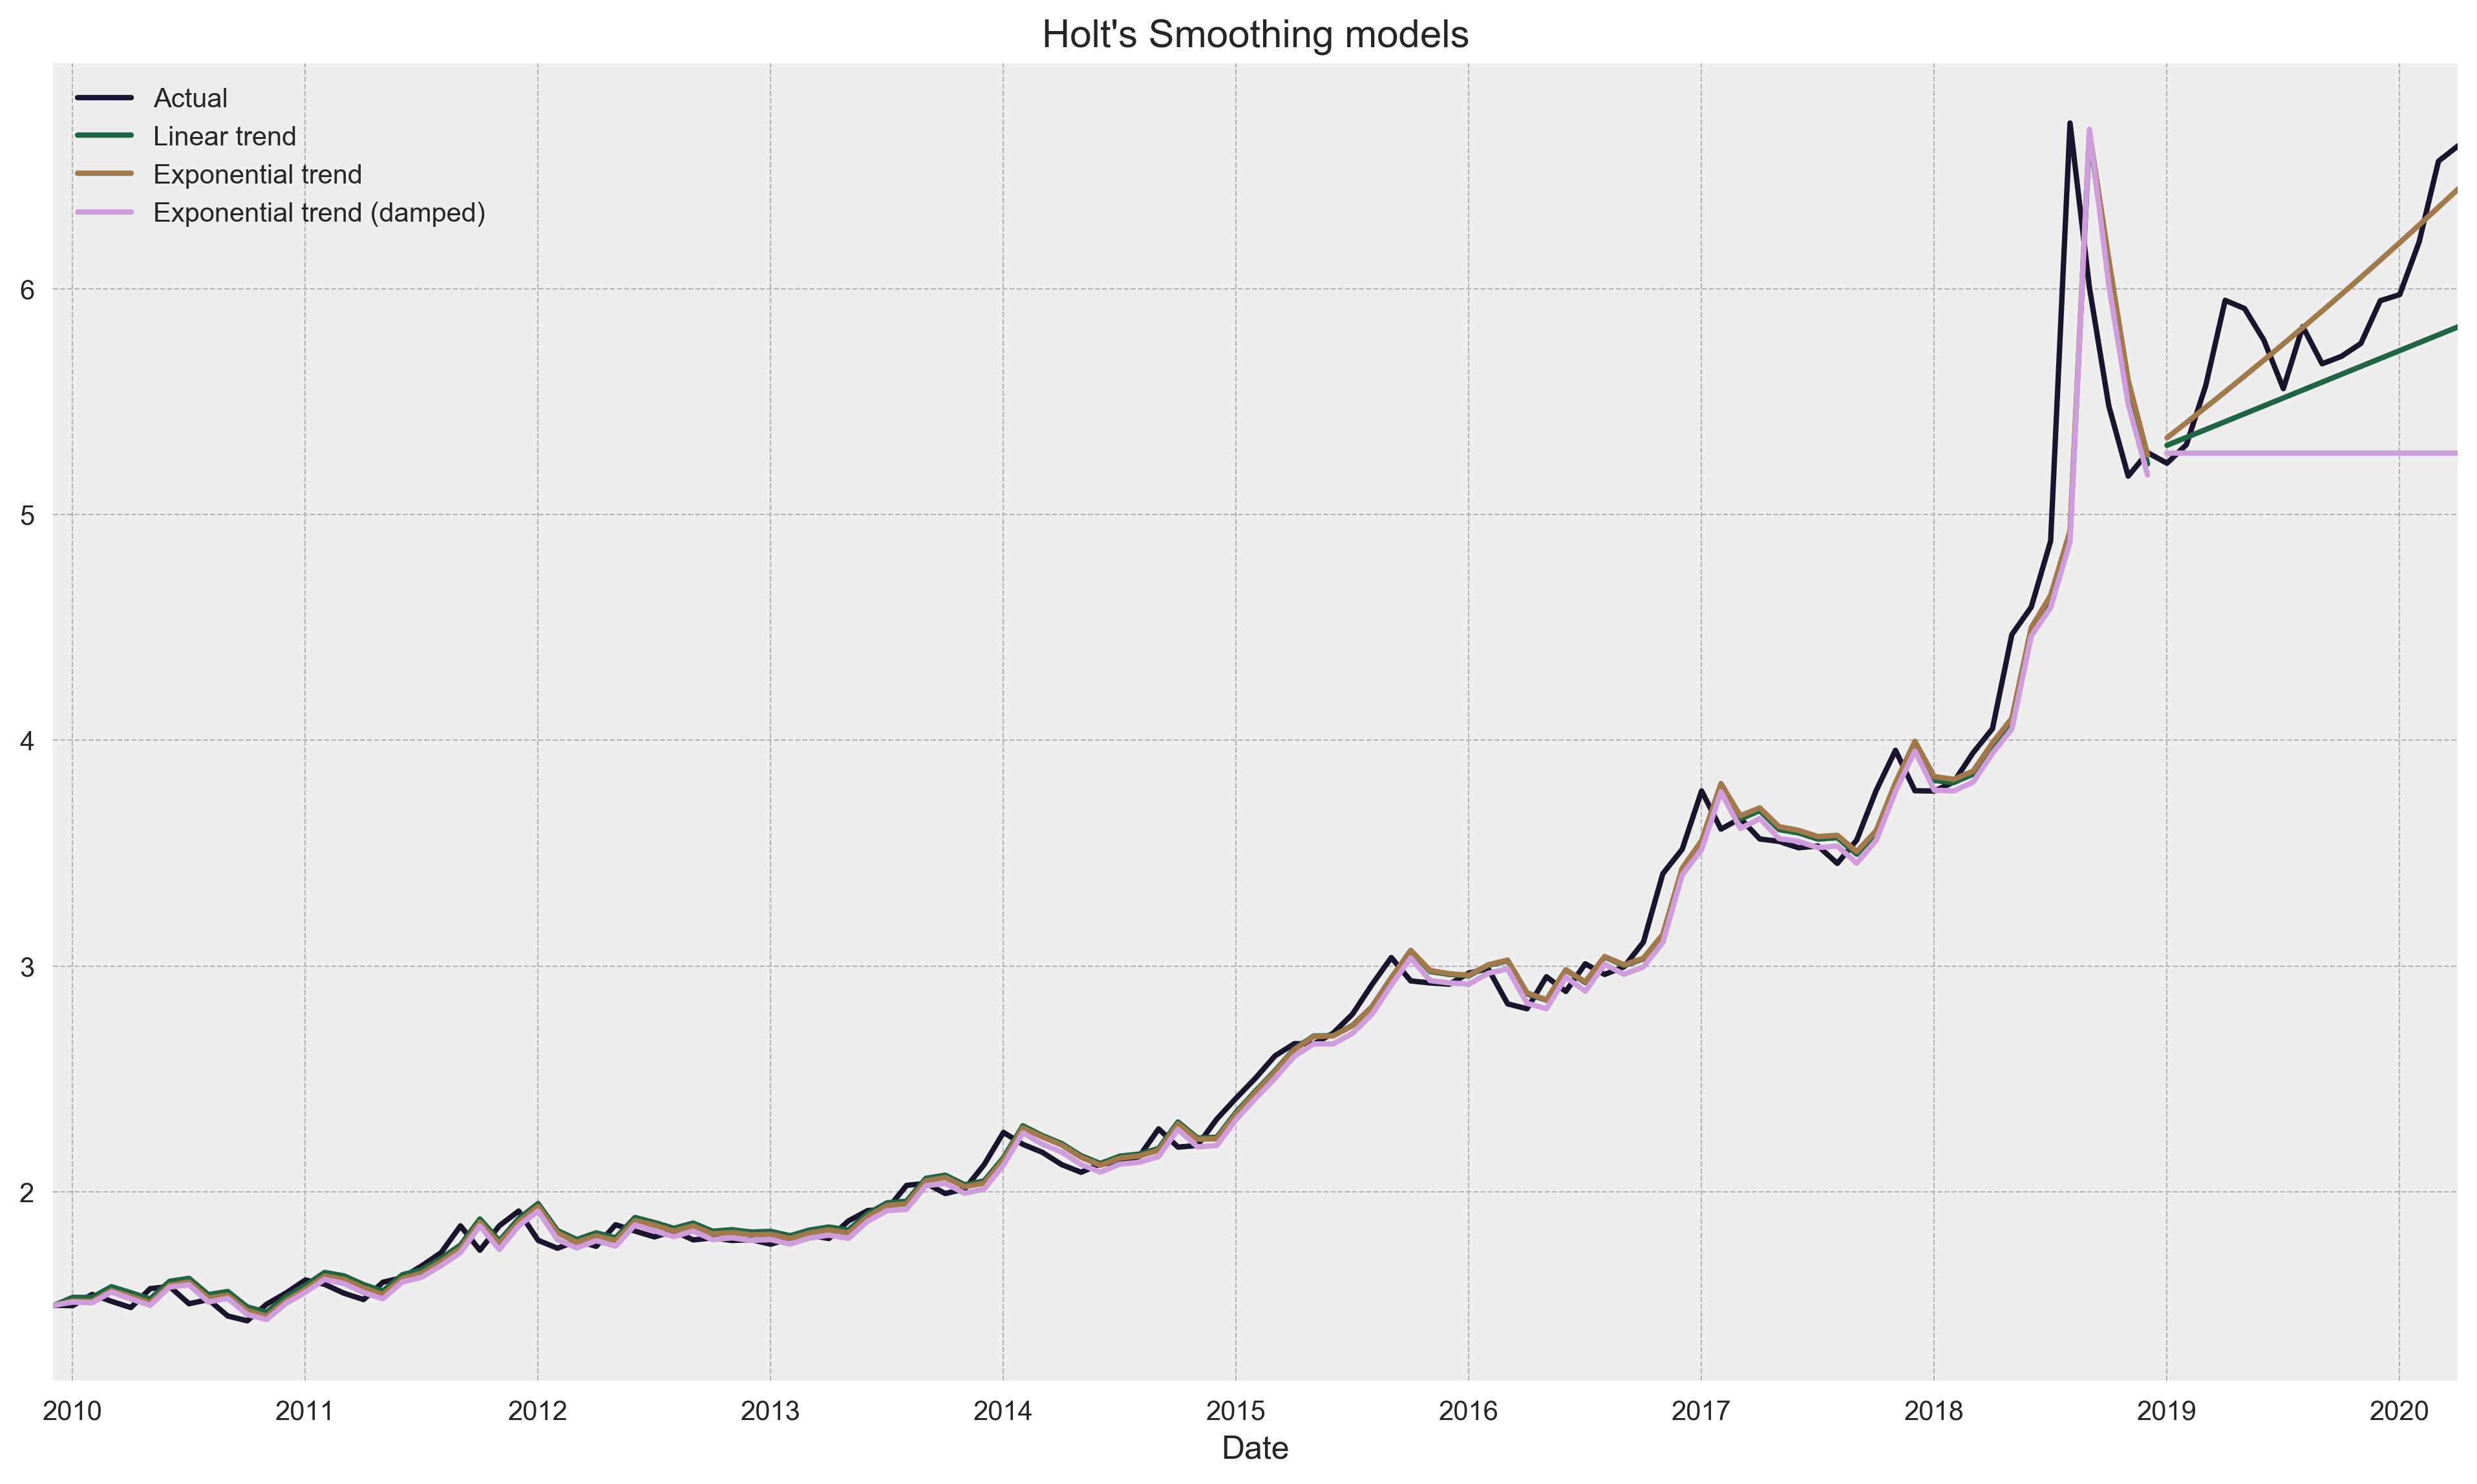

In [215]:
usdtry.plot(color=COLORS[0], title="Holt's Smoothing models", label='Actual', legend=True)
hs_1.fittedvalues.plot(color=COLORS[1])
hs_forecast_1.plot(color=COLORS[1], legend=True, label='Linear trend')
hs_2.fittedvalues.plot(color=COLORS[2])
hs_forecast_2.plot(color=COLORS[2], legend=True, label='Exponential trend')
hs_3.fittedvalues.plot(color=COLORS[3])
hs_forecast_3.plot(color=COLORS[3], legend=True, label='Exponential trend (damped)')

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


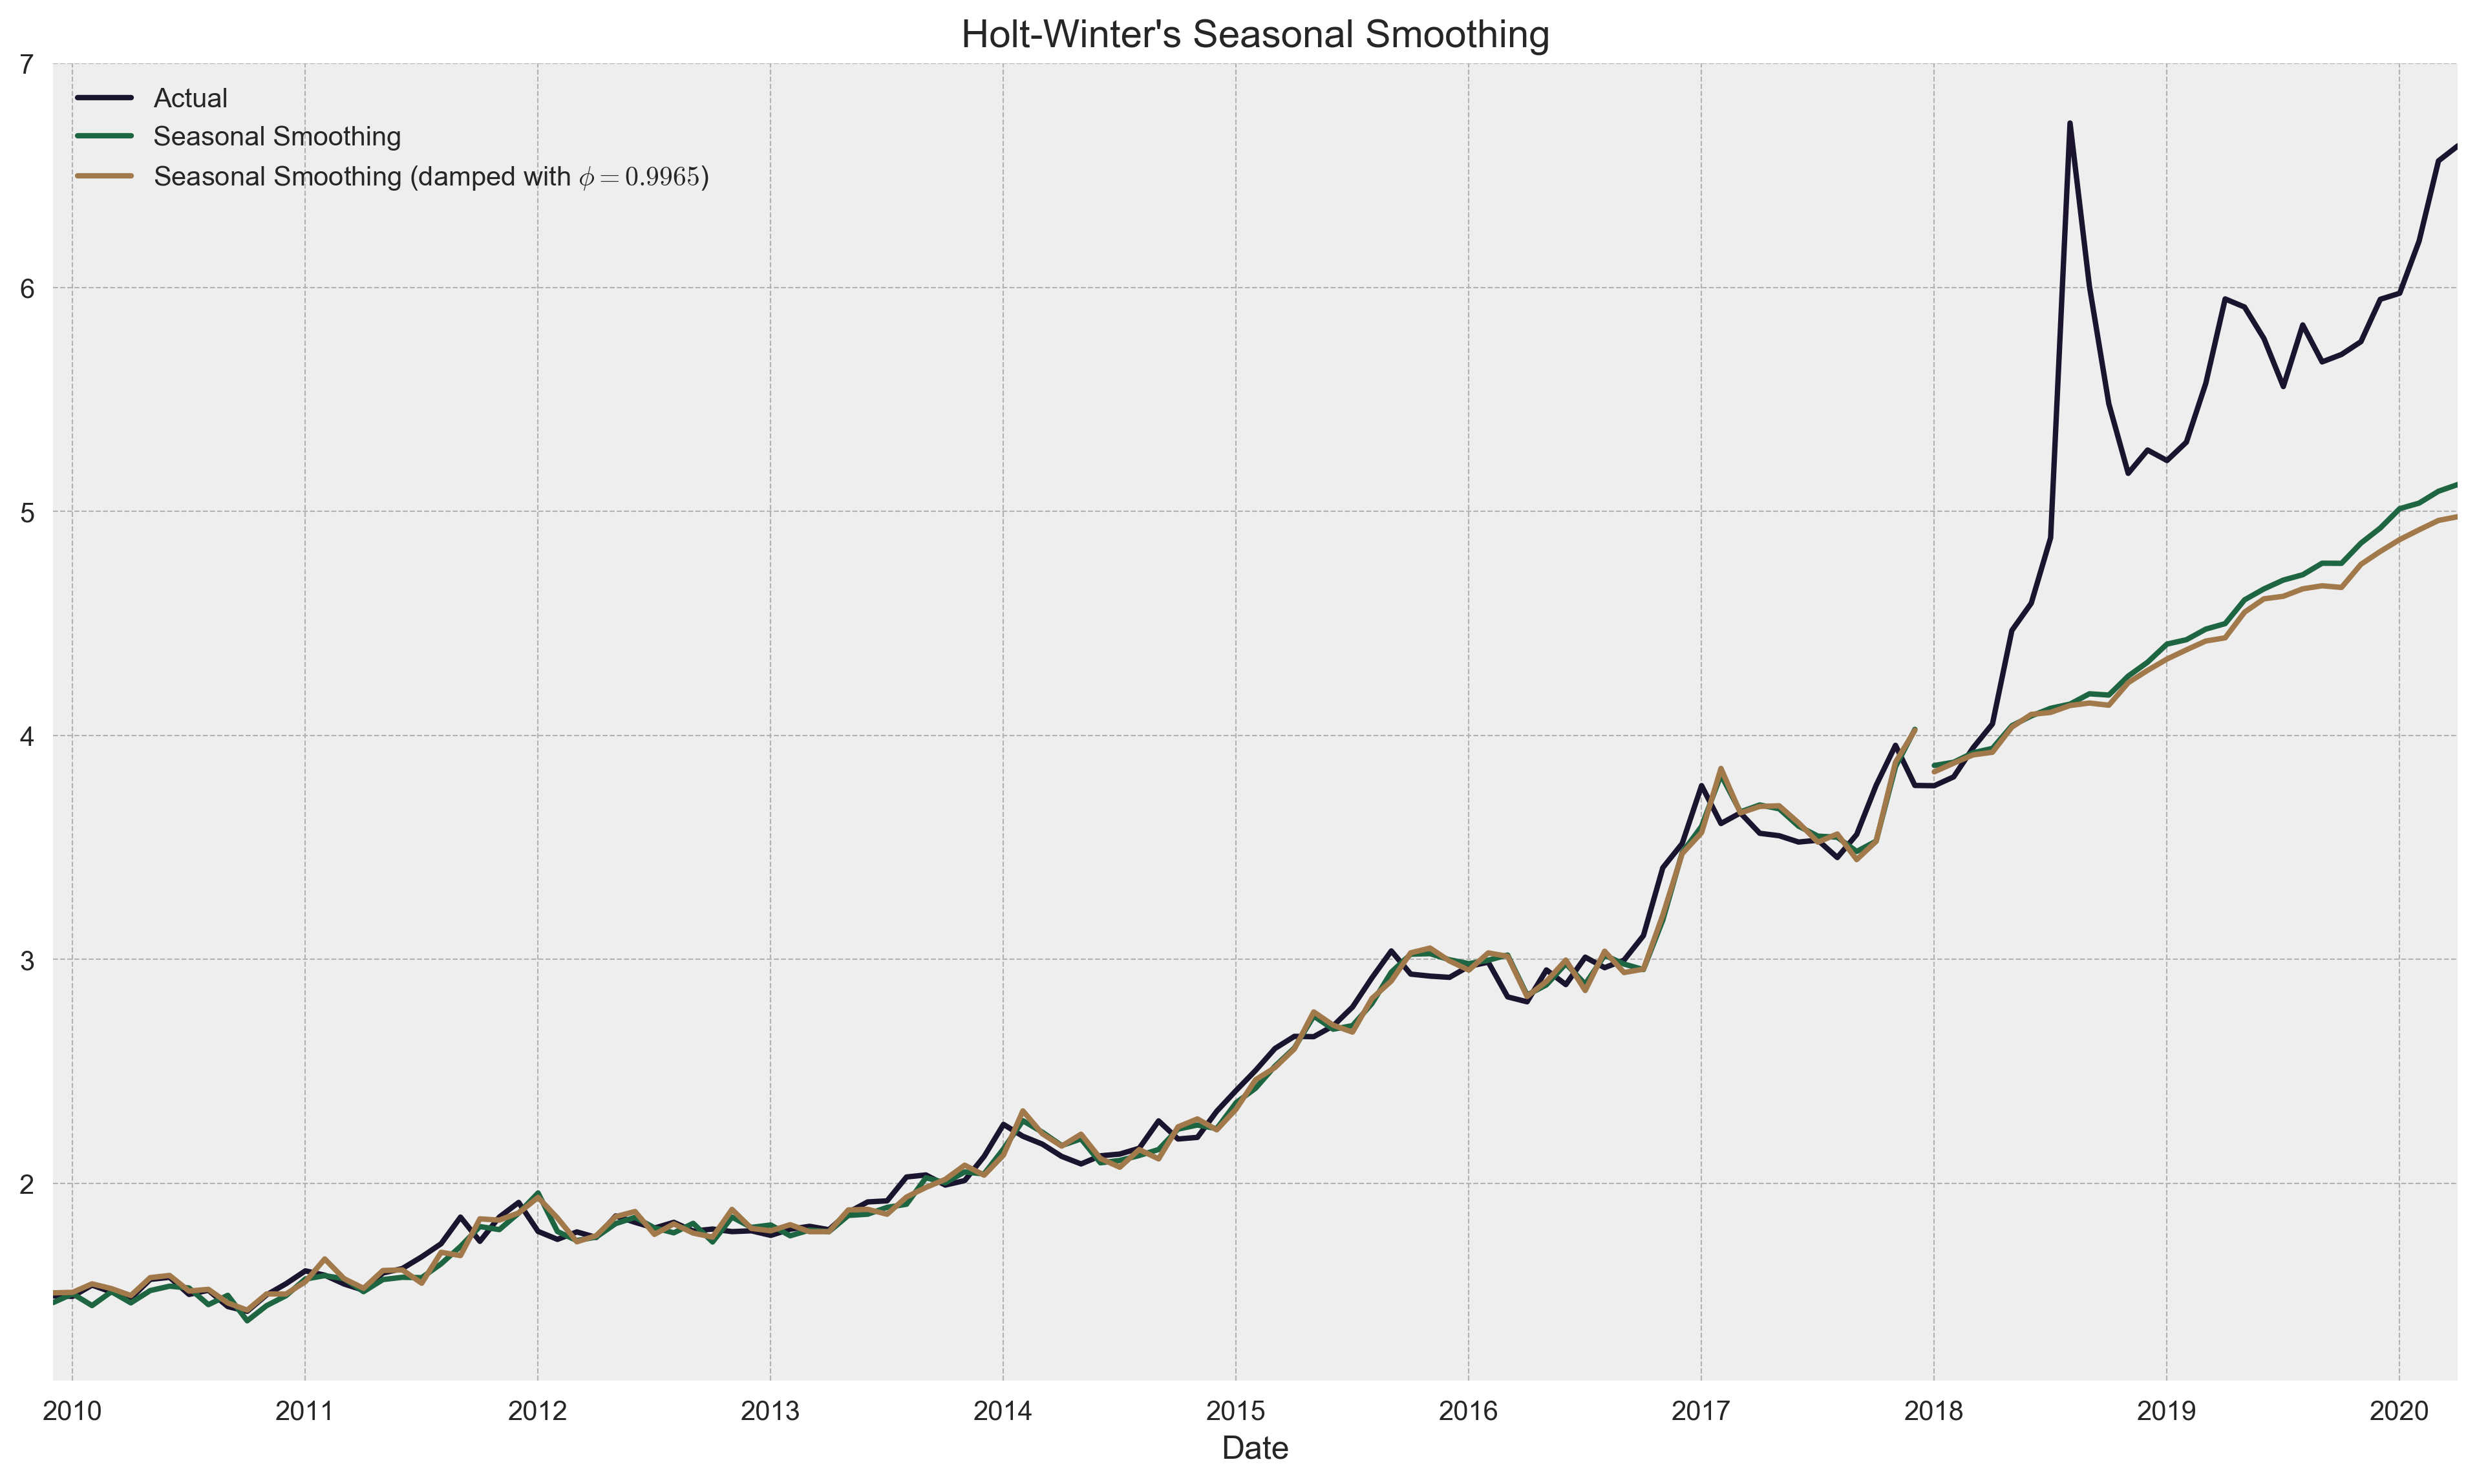

In [225]:
# HOLT'S SEASONALITY SMOOTHING
SEASONAL_PERIODS = 12
# Holt-Winter's model with exponential trend
hw_1 = ExponentialSmoothing(usdtry_train, trend='mul', seasonal='add', seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(test_length)
# Holt-Winter's model with exponential trend and damping
hw_2 = ExponentialSmoothing(usdtry_train, trend='mul', seasonal='add', seasonal_periods=SEASONAL_PERIODS, damped=True).fit()
hw_forecast_2 = hw_2.forecast(test_length)
usdtry.plot(color=COLORS[0], title="Holt-Winter's Seasonal Smoothing", label='Actual', legend=True)
hw_1.fittedvalues.plot(color=COLORS[1])
hw_forecast_1.plot(color=COLORS[1], legend=True, label='Seasonal Smoothing')
phi = hw_2.model.params['damping_slope']
plot_label = f'Seasonal Smoothing (damped with $\phi={phi:.4f}$)'
hw_2.fittedvalues.plot(color=COLORS[2])
hw_forecast_2.plot(color=COLORS[2], legend=True, label=plot_label)
